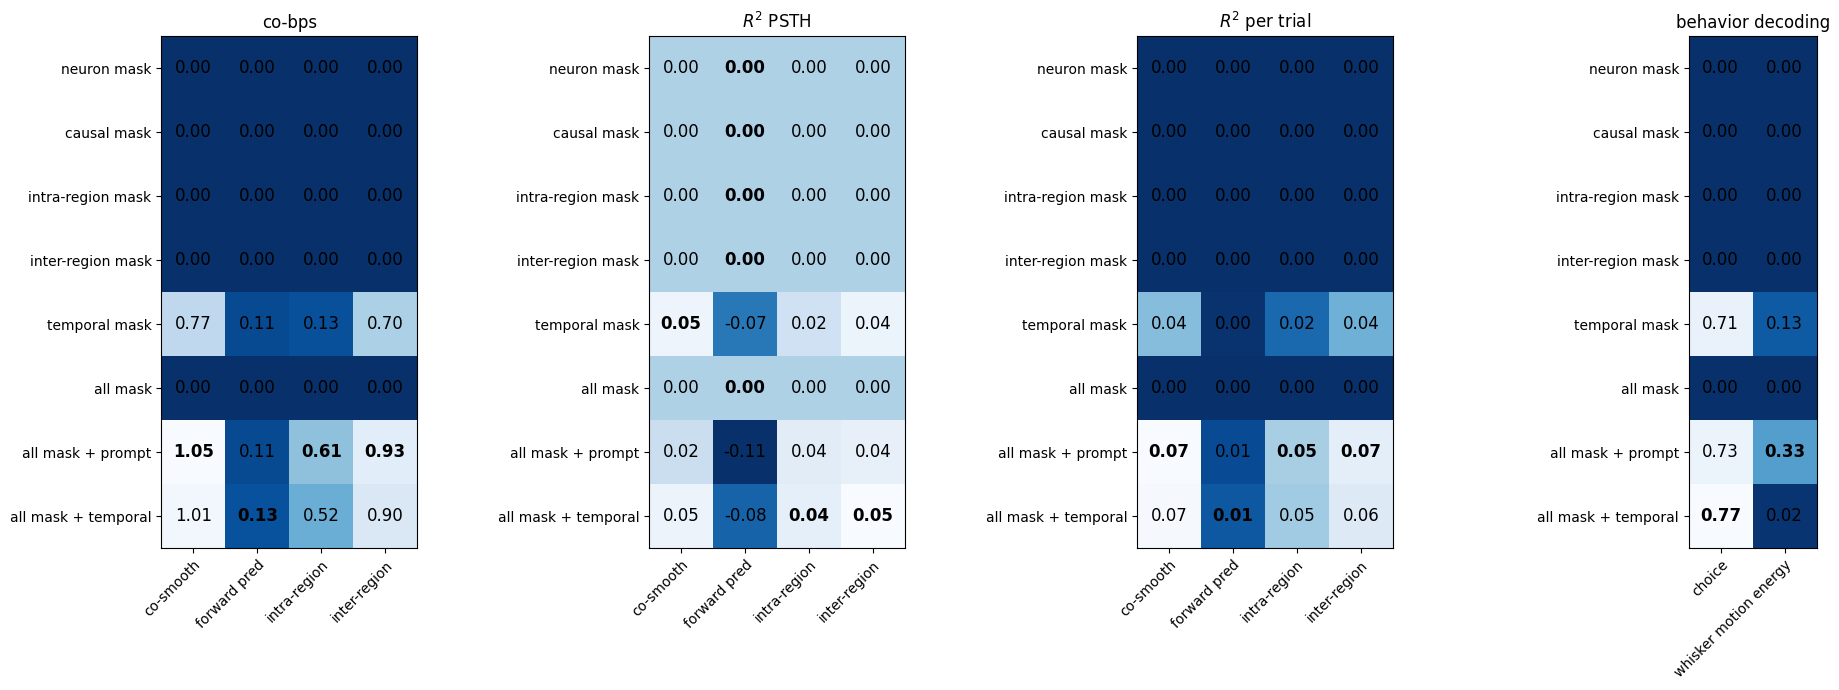

In [35]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

model = "NDT1"

ratio = 0.3
mask_methods = ['mask_neuron', 'mask_causal', 'mask_intra-region', 'mask_inter-region', 'mask_temporal', 'mask_all', 'mask_all_prompt', 'mask_all_temporal']
eval_methods = ['co_smooth', 'forward_pred', 'intra_region', 'inter_region']
finetune_methods = ['choice_decoding', 'continuous_decoding']
behavior_decoders = []

if model == "NDT2":
    mask_methods += ['mask_random_token']

save_path = Path(f'/expanse/lustre/scratch/zwang34/temp_project/results/f140a2ec-fd49-4814-994a-fe3476f14e66/eval/model_{model}/method_ssl')

metrics_dict = {}
for mask in mask_methods:
    metrics_dict[mask] = {}
    if mask == 'mask_all_prompt':
        fname = 'mask_all'
        prompt = 'True'
    elif mask == 'mask_all_temporal':
        fname = mask
        prompt = 'True'
    else:
        fname = mask
        prompt = 'False'
    for eval in eval_methods:
        metrics_dict[mask][eval] = {}
        try:
            r2 = np.load(save_path/fname/f'ratio_{ratio}'/'mask_token_False'/f'prompt_{prompt}'/eval/'r2.npy')
        except:
            r2 = np.zeros(2)
        try:
            bps = np.load(save_path/fname/f'ratio_{ratio}'/'mask_token_False'/f'prompt_{prompt}'/eval/'bps.npy')
        except:
            bps = 0
        metrics_dict[mask][eval]['r2_psth'] = np.nanmean(r2.T[0]) 
        metrics_dict[mask][eval]['r2_per_trial'] = np.nanmean(r2.T[1]) 
        metrics_dict[mask][eval]['bps'] = np.nanmean(bps) 
    for eval in finetune_methods:
        metrics_dict[mask][eval] = {}
        if eval == "choice_decoding":                
            try:
                acc = np.load(save_path/fname/f'ratio_{ratio}'/'mask_token_False'/f'prompt_{prompt}'/eval/'choice_results.npy', allow_pickle=True).item()['acc']
            except:
                acc = np.zeros(1)
            metrics_dict[mask][eval]['metric'] = acc
            
        elif eval == "continuous_decoding":
            try:
                r2 = np.load(
                    save_path/fname/f'ratio_{ratio}'/'mask_token_False'/f'prompt_{prompt}'/eval/'whisker-motion-energy_results.npy', allow_pickle=True
                ).item()['rsquared']
            except:
                r2 = np.zeros(1)

            metrics_dict[mask][eval]['metric'] = r2


decode_metrics = {}
for decoder in behavior_decoders:
    decode_metrics[decoder] = {}
    for eval in finetune_methods:
        decode_metrics[decoder][eval] = {}
        if eval == "choice_decoding":
            try:
                acc = np.load(f'/mnt/home/yzhang1/ceph/results/decoding/choice/{decoder}/671c7ea7-6726-4fbe-adeb-f89c2c8e489b.npy', allow_pickle=True).item()['test_metric']
            except:
                acc = np.zeros(1)
            decode_metrics[decoder][eval][eval] = acc
        elif eval == "continuous_decoding":
            try:
                r2 = np.load(f'/mnt/home/yzhang1/ceph/results/decoding/left-whisker-motion-energy/{decoder}/671c7ea7-6726-4fbe-adeb-f89c2c8e489b.npy', allow_pickle=True).item()['test_metric']
            except:
                r2 = np.zeros(1)
            decode_metrics[decoder][eval][eval] = r2



N = len(mask_methods)
K = len(eval_methods)
M = len(finetune_methods) 
P = len(behavior_decoders)
r2_psth_mat, r2_per_trial_mat, bps_mat = np.zeros((N, K)), np.zeros((N, K)), np.zeros((N, K))
behave_mat = np.zeros((N + P, M))
for i, mask in enumerate(mask_methods):
    for j, eval in enumerate(eval_methods):
        r2_psth_mat[i,j] = metrics_dict[mask][eval]['r2_psth']
        r2_per_trial_mat[i,j] = metrics_dict[mask][eval]['r2_per_trial']
        bps_mat[i,j] = metrics_dict[mask][eval]['bps']
    for j, eval in enumerate(finetune_methods):
        behave_mat[i,j] = metrics_dict[mask][eval]['metric']
   
for i, decoder in enumerate(behavior_decoders):
    for j, eval in enumerate(finetune_methods):
        behave_mat[i+N,j] = decode_metrics[decoder][eval]['metric']


fig, axes = plt.subplots(1, 4, figsize=(20, 7))

mat = bps_mat
im0 = axes[0].imshow(mat, cmap='Blues_r')
axes[0].set_title("co-bps")

for j in range(len(eval_methods)):
    for i in range(len(mask_methods)):
        color = 'w' if mat[i, j] < -0.5 else 'k'
        if mat[i, j] == mat[:, j].max(): 
            text = axes[0].text(j, i, f'{mat[i, j]:.2f}',
                       ha="center", va="center", color=color, fontsize=12, weight='bold')
        else:
            text = axes[0].text(j, i, f'{mat[i, j]:.2f}',
                       ha="center", va="center", color=color, fontsize=12)

mat = r2_psth_mat
im1 = axes[1].imshow(mat, cmap='Blues_r')
axes[1].set_title(r"$R^2$ PSTH")

for i in range(len(mask_methods)):
    for j in range(len(eval_methods)):
        color = 'w' if mat[i, j] < -0.5 else 'k'
        if mat[i, j] == mat[:, j].max(): 
            text = axes[1].text(j, i, f'{mat[i, j]:.2f}',
                       ha="center", va="center", color=color, fontsize=12, weight='bold')
        else:
            text = axes[1].text(j, i, f'{mat[i, j]:.2f}',
                       ha="center", va="center", color=color, fontsize=12)

mat = r2_per_trial_mat
im2 = axes[2].imshow(mat, cmap='Blues_r')
axes[2].set_title(r"$R^2$ per trial")

for i in range(len(mask_methods)):
    for j in range(len(eval_methods)):
        color = 'w' if mat[i, j] < -0.5 else 'k'
        if mat[i, j] == mat[:, j].max(): 
            text = axes[2].text(j, i, f'{mat[i, j]:.2f}',
                       ha="center", va="center", color=color, fontsize=12, weight='bold')
        else:
            text = axes[2].text(j, i, f'{mat[i, j]:.2f}',
                       ha="center", va="center", color=color, fontsize=12)

mat = behave_mat
im2 = axes[3].imshow(mat, cmap='Blues_r')
axes[3].set_title(r"behavior decoding")

for i in range(N+P):
    for j in range(len(finetune_methods)):
        color = 'w' if mat[i, j] < -0.5 else 'k'
        if mat[i, j] == mat[:, j].max(): 
            text = axes[3].text(j, i, f'{mat[i, j]:.2f}',
                       ha="center", va="center", color=color, fontsize=12, weight='bold')
        else:
            text = axes[3].text(j, i, f'{mat[i, j]:.2f}',
                       ha="center", va="center", color=color, fontsize=12)

for i, ax in enumerate(axes):
    if model == "NDT2":
        ax.set_yticks(np.arange(N), labels=['neuron mask','causal mask', 'intra-region mask', 'inter-region mask', 'temporal mask', 'neuron+temporal+causal mask', 'all mask', 'random token mask'])
    else:
        ax.set_yticks(np.arange(N), labels=['neuron mask','causal mask', 'intra-region mask', 'inter-region mask', 'temporal mask', 'all mask', 'all mask + prompt', 'all mask + temporal'])
    if i < len(axes)-1:
        ax.set_xticks(np.arange(K), labels=['co-smooth','forward pred', 'intra-region', 'inter-region'])
    else:
        ax.set_xticks(np.arange(M), labels=['choice', 'whisker motion energy'])
        ax.set_yticks(np.arange(N+P), 
                # labels=['neuron mask','causal mask', 'intra-region mask', 'inter-region mask', 'temporal mask', 'all mask', 'all mask + prompt', 'linear', 'reduced-rank', 'mlp'])
                labels=['neuron mask','causal mask', 'intra-region mask', 'inter-region mask', 'temporal mask', 'all mask', 'all mask + prompt', 'all mask + temporal'])
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

fig.tight_layout()
# plt.savefig(f'results/table/{model}_metrics.png')


In [20]:
x = np.load('/expanse/lustre/scratch/zwang34/temp_project/results/7cb81727-2097-4b52-b480-c89867b5b34c/eval/model_NDT1/method_ssl/mask_all_temporal/ratio_0.3/mask_token_False/prompt_True/choice_decoding/choice_results.npy', allow_pickle=True)

In [23]:
metrics_dict

{'mask_neuron': {'co_smooth': {'r2_psth': 0.11368819588768589,
   'r2_per_trial': 0.07570473678953428,
   'bps': 1.0380833429369334},
  'forward_pred': {'r2_psth': -0.043210980014368953,
   'r2_per_trial': 0.009446882189060835,
   'bps': -0.20902777065698713},
  'intra_region': {'r2_psth': -0.1014493069005395,
   'r2_per_trial': 0.004086842512410839,
   'bps': -0.2155019410975787},
  'inter_region': {'r2_psth': 0.074767785063728,
   'r2_per_trial': 0.05259918398414889,
   'bps': 0.7818350687736675},
  'choice_decoding': {'metric': 0.7153846153846154},
  'continuous_decoding': {'metric': 0.33926371152584367}},
 'mask_causal': {'co_smooth': {'r2_psth': 0.036718093626645014,
   'r2_per_trial': 0.022282959853380975,
   'bps': 0.43640287148208934},
  'forward_pred': {'r2_psth': -0.025981722134832297,
   'r2_per_trial': 0.03004259755403509,
   'bps': 0.48007917215294205},
  'intra_region': {'r2_psth': -0.05889595708583917,
   'r2_per_trial': -0.005456563280276175,
   'bps': -0.36198069840133